## Landscape Simulation

This notebook outlines a few methods related to methods of landscape simulation.  These include basic cellular automata, probabilistic cellular automata, sampling from probability distributions, Markov model and spatial Markov models.

The Game of Life and similar cellular automata, with synchronous update, can be programmed simply using logic like the following:

In [1]:
import pylab as plt
import numpy as np
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
import imageio
import os

In [2]:
# Game of life rules:
# 1.Any live cell with fewer than two live neighbours dies, as if caused by under-population.
# 2.Any live cell with two or three live neighbours lives on to the next generation.
# 3.Any live cell with more than three live neighbours dies, as if by overcrowding.
# 4.Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.

# Assumes t is a binary array, 0=off, 1=on, x and y are coordinate within t.
def get_new_state(t, x, y):
    
    # Default is for cell to stay the same
    new_state = t[x, y]
    
    # Count adjacent on cells, skipping edges.
    num_adjacent_on = 0
    if (x > 0) and (x < t.shape[1]-1) and (y > 0) and (y < t.shape[0]-1):
    
        # Loop around neighboring pixels
        for i in range(x-1, x+2):
            for j in range(y-1, y+2):
                if (i != x) or (j != y):
                    num_adjacent_on += t[i, j]

        if t[x, y] == 1: # This is a live cell
            if num_adjacent_on < 2:
                new_state = 0
            if num_adjacent_on > 3:
                new_state = 0

        if t[x, y] == 0: # this is a dead cell
            if num_adjacent_on == 3:
                new_state = 1

    return new_state

The following function takes care of some of the overhead by generating a random raster and iterating through the cells applying the get_new_state rule.

In [3]:
def run_ca():
    # Generate input rasters in 2 dimensions
    dim = 50
    t0 = np.zeros((dim, dim))
    t1 = np.zeros((dim, dim))

    # Initialize to random on/off states
    t0 = np.random.random(size=(dim, dim))
    t0 = (t0 < 0.2).astype(dtype=np.uint8)
    file_names = []
    for i in range(10):
        # Update all cells
        for x in range(dim):
            for y in range(dim):
                t1[x, y] = get_new_state(t0, x, y)
        t0 = t1.copy()  # assignment is by reference; we want a separate copy, so use np.copy.
        # Show/save the current file
        plt.matshow(t1,fignum=100,cmap=plt.cm.gray)
        file_name = '{0}.png'.format(i)    
        plt.savefig(file_name)
        file_names.append(file_name)

    # Assemble into animation - requires imageio
    images = []
    for filename in file_names:
        images.append(imageio.imread(filename))
    movie_name = "./movie_" + str(np.random.randint(100000)) + ".gif"
    imageio.mimsave(movie_name, images)
    # Clean up
    for filename in file_names:
        os.remove(filename)
    display(HTML('<img src="' + movie_name + '">'))

We can try experimenting with different rules, for example, voter model - picking the most commonly-found neighbor:

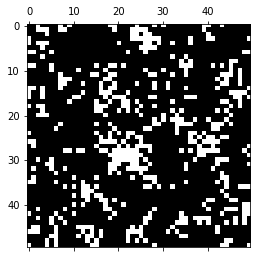

In [5]:
# Replaces the game of life rules with voter model.
def get_new_state(t, x, y):
    
    # Default is for cell to stay the same
    new_state = t[x, y]
    
    # Count adjacent on cells, skipping edges.
    num_adjacent_on = 0
    if (x > 0) and (x < t.shape[1]-1) and (y > 0) and (y < t.shape[0]-1):
    
        # Variation on basic model - select randomly from among neighbors:
        selection = np.random.randint(8)
        neighbors = []
        for i in range(x-1, x+2):
            for j in range(y-1, y+2):
                if (i != x) or (j != y):
                    neighbors.append(t[i, j])
        new_state = neighbors[selection]
    return new_state

run_ca()

Or, only expanding:

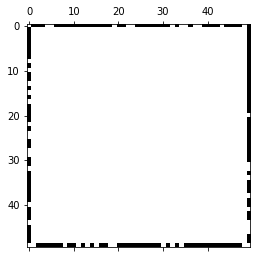

In [6]:
def get_new_state(t, x, y):
    
    # Default is for cell to stay the same
    new_state = t[x, y]
    
    # Count adjacent on cells, skipping edges.
    num_adjacent_on = 0
    if (x > 0) and (x < t.shape[1]-1) and (y > 0) and (y < t.shape[0]-1):
    
        # Variation on basic model - select randomly from among neighbors:
        selection = np.random.randint(8)
        neighbors = []
        for i in range(x-1, x+2):
            for j in range(y-1, y+2):
                if (i != x) or (j != y):
                    neighbors.append(t[i, j])
        if neighbors[selection]:
            new_state = neighbors[selection]
    return new_state

run_ca()

Or, a probabilistic version, where probability is determined by the number of adjacent cells, the more cells are on, the higher the probability:

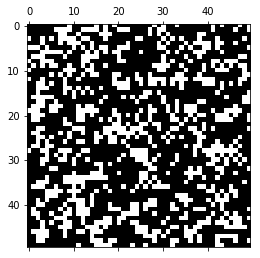

In [7]:
def get_new_state(t, x, y):
    
    # Default is for cell to stay the same
    new_state = t[x, y]
    
    # Count adjacent on cells, skipping edges.
    num_adjacent_on = 0
    p = [i * 0.01 for i in range(9)]
    if (x > 0) and (x < t.shape[1]-1) and (y > 0) and (y < t.shape[0]-1):
        for i in range(x-1, x+2):
            for j in range(y-1, y+2):
                if (i != x) or (j != y):
                    num_adjacent_on += int(t[i, j])
        if np.random.random() < p[num_adjacent_on]:
            new_state = 1
    return new_state

run_ca()

Adding a probabilistic element can improve the realism of these kinds of models.  Before we get to this, it may be helpful to look at how to deal with sampling probability distributions.

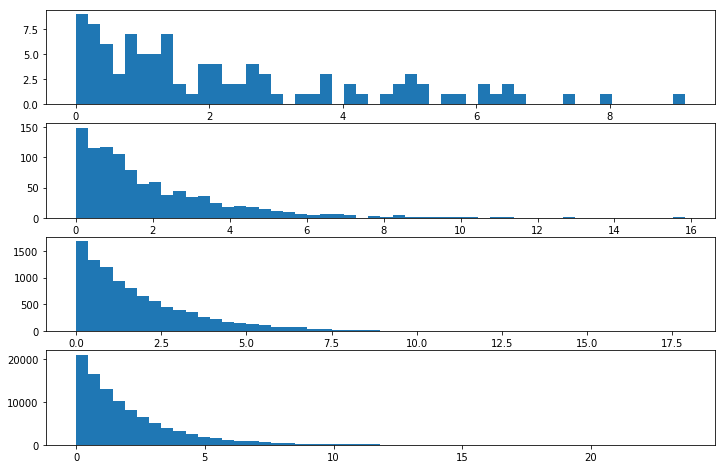

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

def sample(num_samples):
    # return np.random.random(num_samples)
    # return np.random.normal(0, 1, num_samples)
    # return np.random.pareto(5, num_samples)
    # return np.random.weibull(2, num_samples)
    # return np.random.logistic(0, 1, num_samples)
    return np.random.exponential(2, num_samples)

fig = plt.figure()

p = fig.add_subplot(411)
p.hist(sample(100), 50)

p = fig.add_subplot(412)
p.hist(sample(1000), 50)

p = fig.add_subplot(413)
p.hist(sample(10000), 50)

p = fig.add_subplot(414)
p.hist(sample(100000), 50)

plt.show()

This gives us access to a certain range of distributions.  We can also generate samples by transforming the results of a uniform distribution. One way of accomplishing this transformation is to draw a random uniform sample between zero and one, and then find the function that would generate that value, or the inverse of the function.

https://en.wikipedia.org/wiki/Inverse_transform_sampling

Here's a simple example with the exponential distribution:


https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.exponential.html

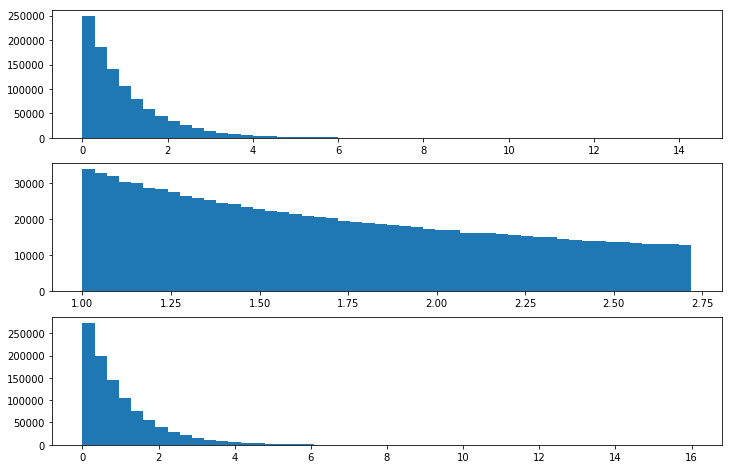

In [9]:
def sample_np(num_samples):
    return np.random.exponential(size=num_samples)

def sample_function(num_samples):
    x = np.random.random(num_samples) # Sample from uniform disribution (0 to 1)
    return np.exp(x) 

def sample_inverse(num_samples):
    x = np.random.random(num_samples) # Sample from uniform disribution (0 to 1)
    return -np.log(x) # Inverse of exponential
    
fig = plt.figure()
p = fig.add_subplot(311)
p.hist(sample_np(1000000), 50)

p = fig.add_subplot(312)
p.hist(sample_function(1000000), 50)

p = fig.add_subplot(313)
p.hist(sample_inverse(1000000), 50)
plt.show()

For a emprical distribution gathered by counting discrete values (e.g., landcover types), we can count the number in each bin, and sample values by mapping uniform numbers to those bin sizes.  For example:

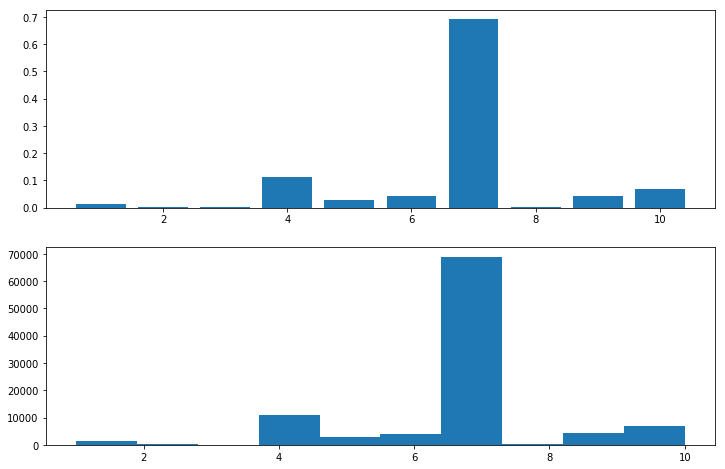

In [10]:
# Values, e.g., landcover type labels
values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Empirical count, e.g., number of values per category
counts = np.array([100., 20., 5., 800., 200., 300., 5000., 10., 300., 500.])

# Transformed to probability (summing to 1)
distribution = counts / counts.sum()

def sample(num_samples):    
    result = []
    # Drawing samples with the same distribution as the original counts
    for i in range(num_samples):
        acc = 0
        # Draw a random number between zero and one
        threshold = np.random.rand()
        for j in range(distribution.shape[0]):
            # Sum up the values in the distribution, making it cumulative.  If the uniformly
            # random value exceeds the cumulative total, return the value associated with 
            # the selected index.
            acc += distribution[j]
            if acc >= threshold:
                result.append(values[j])
                break
    return result

fig = plt.figure()
p = fig.add_subplot(211)
p.bar(values, distribution)

p = fig.add_subplot(212)
p.hist(sample(100000), 10)
plt.show()

Another method is to calculate a cumulative probability distribution and sample from that, which can be handy for functions that are difficult to invert.  For example, the Gaussian function is hard to invert:

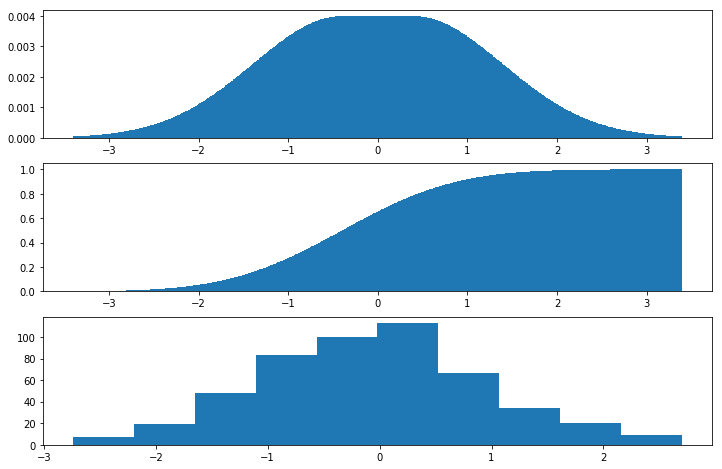

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math


def gaussian(x, mu, sigma):
    exp_part = -0.5 * ((x - mu) / sigma) ** 2.0
    denominator = sigma * math.sqrt(2.0 * math.pi)
    result = (math.e ** exp_part) / denominator
    return result

def cumulative(dist):
    cumulative_dist = np.zeros(dist.shape)
    acc = 0
    for i in range(dist.shape[0]):
        acc += dist[i]
        cumulative_dist[i] = acc
    return cumulative_dist

def sample(num_samples, inputs):
    result = np.zeros((num_samples,))
    x = np.random.random(num_samples)
    for i in range(num_samples):
        threshold = x[i]
        for j in range(cumulative_dist.shape[0]):
            if cumulative_dist[j] > threshold:
                result[i] = inputs[j]
                break
    return result

inputs = np.arange(-3, 3, 0.01)
d = gaussian(inputs, 0, 1)
dist = d / sum(d)
cumulative_dist = cumulative(dist)

fig = plt.figure()
p = fig.add_subplot(311)
p.bar(inputs, dist)

p = fig.add_subplot(312)
p.bar(inputs, cumulative_dist)

p = fig.add_subplot(313)
simulated = sample(500, inputs)
p.hist(simulated)
plt.show()

Now, we can use sampling from distributions to do some more interesting things with our simulation - consider cells not as binary on/off, but as having either categorical class lables or containing continuous values. For example:

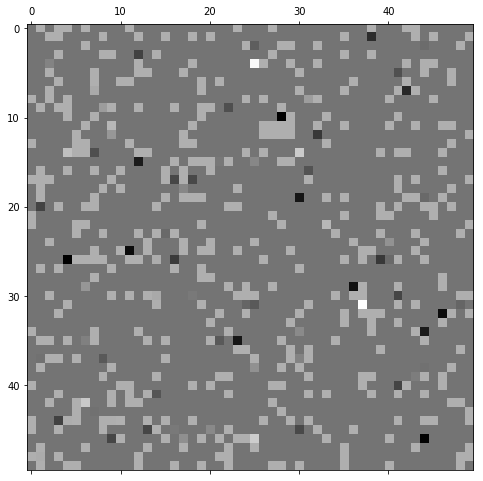

In [12]:
def get_new_state(t, x, y):
    
    # Default is for cell to stay the same
    new_state = t[x, y]
    
    # Count adjacent on cells, skipping edges.
    num_adjacent_on = 0
    if (x > 0) and (x < t.shape[1]-1) and (y > 0) and (y < t.shape[0]-1):
    
        # Set cell values  as some 
        selection = np.random.randint(8)
        random_scale = np.random.normal()
        neighbors = []
        for i in range(x-1, x+2):
            for j in range(y-1, y+2):
                if (i != x) or (j != y):
                    neighbors.append(t[i, j])
        if np.random.random() < 0.02:
            new_state = neighbors[selection] * random_scale
    return new_state

run_ca()

One thing we can do with probability distributions is to derive them from data by counting cells.  Here's an example using MODIS land cover (MCD12Q1) for an area in southern Borneo, for 2001, 2006, and 2011:

MCD12Q1.A2001001.h29v09.051.2012157222123.tif

MCD12Q1.A2006001.h29v09.051.2012272203650.tif

MCD12Q1.A2011001.h29v09.051.2012264183343.tif

We can work with these conveniently by loading them in to numpy with gdal.

Now, the publishers of the MCD12Q1 dataset don't recommend using it for time series analysis, so don't try to do this in a thesis project, but it should allow us to take a look at the concepts.

https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mcd12q1

But first we should simplify the types so that all the transitions have plenty of examples: let's merge all the forest types, all the savannah types, all the non-tree types, and water/other.

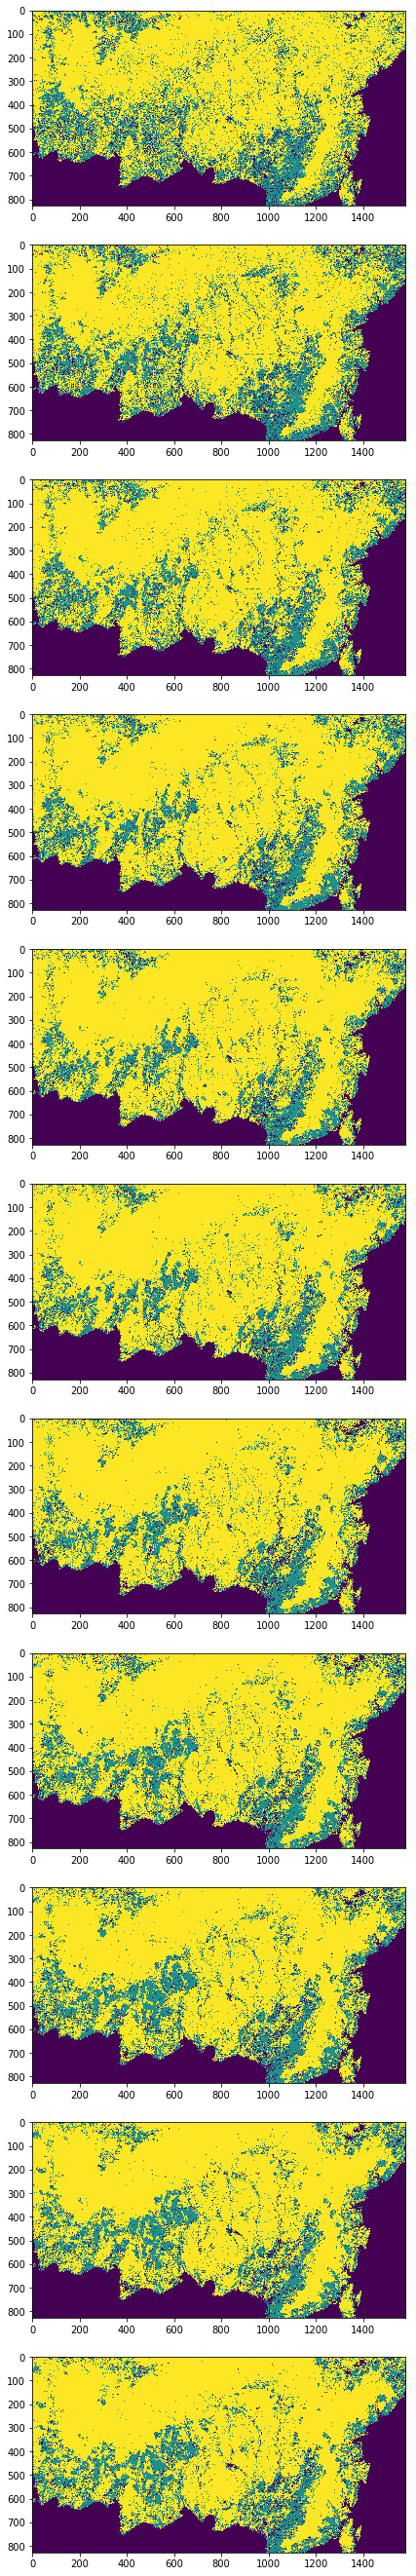

In [13]:
import numpy as np
from osgeo import gdal
plt.rcParams['figure.figsize'] = (12, 48)

file_names = ["MCD12Q1.A2001001.h29v09.051.2012157222123.tif", 
    "MCD12Q1.A2002001.h29v09.051.2012157224844.tif", 
    "MCD12Q1.A2003001.h29v09.051.2012158160147.tif", 
    "MCD12Q1.A2004001.h29v09.051.2012158165120.tif", 
    "MCD12Q1.A2005001.h29v09.051.2012272202951.tif", 
    "MCD12Q1.A2006001.h29v09.051.2012272203650.tif", 
    "MCD12Q1.A2007001.h29v09.051.2012159190500.tif", 
    "MCD12Q1.A2008001.h29v09.051.2012158182917.tif", 
    "MCD12Q1.A2009001.h29v09.051.2012158204624.tif", 
    "MCD12Q1.A2010001.h29v09.051.2012158212343.tif", 
    "MCD12Q1.A2011001.h29v09.051.2012264183343.tif"]

def get_file_data(file_name):
    ds = gdal.Open(file_name)
    arr = np.array(ds.GetRasterBand(1).ReadAsArray())
    arr[np.isin(arr, [0, 11, 13, 15, 16, 254, 255])] = 0
    arr[np.isin(arr, [1, 2, 3, 4, 5])] = 2
    arr[np.isin(arr, [6, 7, 8, 9, 10, 12, 14])] = 1
    return arr

# Let's look at the data and see what we have
fig = plt.figure()
data = []
for i in range(len(file_names)):
    d = get_file_data(file_names[i])
    data.append(d)
    p = fig.add_subplot(11,1,i+1)
    p.imshow(d)
plt.show()

This gives us data for a few time steps to draw from.  To calculate transition probabilities, it is straightforward to build a transition matrix by counting transitions.

In [14]:
num_types = 3

t0 = data[0]  # 2001
t1 = data[5]  # 2006
t2 = data[10]  # 2011

# Get the transition counts
trans_c = np.zeros((num_types, num_types))
for r in range(num_types):
    for c in range(num_types):
        trans_c[r, c] += (t1[t0==r] == c).sum()

# Convert to transition probabilities
trans_p = np.zeros((num_types, num_types))
for c in range(num_types):
    column_total = trans_c[:, c].sum()
    for r in range(num_types):
        trans_p[r, c] += trans_c[r, c] / column_total

# Sanity check to make sure the columns add up to 1
print(trans_p)
print(trans_p.sum(axis=0))

[[ 0.89218505  0.10888538  0.03272287]
 [ 0.06473853  0.57938384  0.15674694]
 [ 0.04307641  0.31173077  0.81053019]]
[ 1.  1.  1.]


Now that we have these transition probabilities, we can project forward by sampling from them stochastically.  For example:

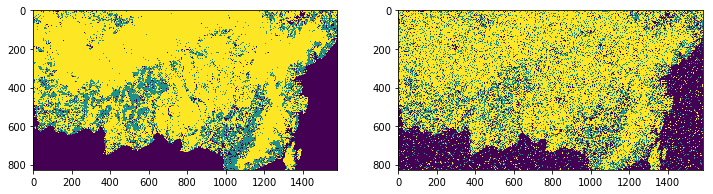

In [22]:
plt.rcParams['figure.figsize'] = (12, 12)

t3 = np.copy(t1)

for r in range(t3.shape[0]):
    for c in range(t3.shape[1]):
        j = t2[r, c]  # Current value - column in transition matrix
        thresh = np.random.random() # Get random threshold
        acc = 0
        for i in range(num_types):  # Pick the row probabilistically
            acc += trans_p[i, j]
            if thresh < acc:
                t3[r, c] = i
                break

fig = plt.figure()
p = fig.add_subplot(121)
p.imshow(t2)
p = fig.add_subplot(122)
p.imshow(t3)
plt.show()

Well, that's interesting, but isn't realistic, because there is no spatial componnt to the simulation.  We can add a spatial context by creating another input surface, which captures the spatial context of each cell.  We can guess that cells surrounded by cells of the same type are less likely to change.

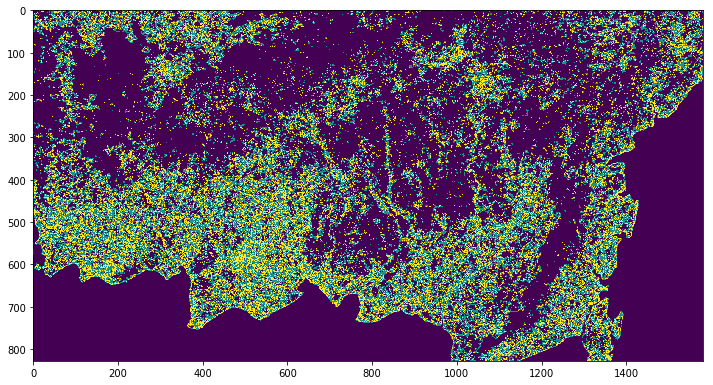

In [31]:
def get_spatial_context(t0):
    spatial_context = np.zeros(t0.shape, dtype=np.uint8)
    for r in range(t0.shape[0]):
        for c in range(t0.shape[1]):
            cur_val = t0[r, c]
            num_other_class = 0
            if (r > 0) and (r < t0.shape[0]-1) and (c > 0) and (c < t0.shape[1]-1):
                for i in range(r-1, r+2):
                    for j in range(c-1, c+2):
                        if (i != r) or (j != c):
                            if cur_val != t0[i, j]:
                                num_other_class += 1

            if num_other_class <= 1:
                spatial_context[r, c] = 0
            elif num_other_class <= 4:
                spatial_context[r, c] = 1
            else:
                spatial_context[r, c] = 2
    return spatial_context
 
plt.imshow(get_spatial_context(t0)) 

Now we can use this definition of spatial context to add a spatial component to tne simulation.

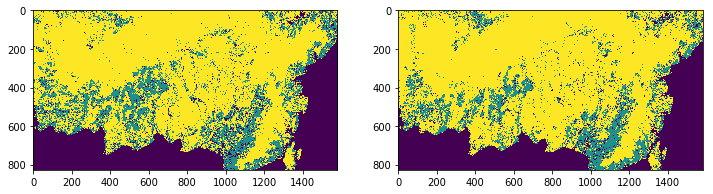

In [34]:
t3 = np.copy(t1)

spatial_context = get_spatial_context(t1)
for r in range(t1.shape[0]):
    for c in range(t1.shape[1]):
        s = spatial_context[r, c]
        j = t1[r, c]  # Current value - column in transition matrix
        thresh = np.random.random() # Get random threshold
        acc = 0
        # Now we can apply more spatial rules:
        # Assume that non-vegetated areas and water don't change:
        if s == 2:
            for i in range(num_types):  # Pick the row probabilistically
                acc += trans_p[i, j]
                if thresh < acc:
                    t3[r, c] = i
                    break
        
fig = plt.figure()
p = fig.add_subplot(121)
p.imshow(t2)
p = fig.add_subplot(122)
p.imshow(t3)
plt.show()

The estimated raster can then be compared to the actual raster using, e.g., Kappa index of agreement.